# Note on training:

Rather than data being the image and target being the correct value, the data will be three images and the target will be which image is more similar to the first image.

Create a custom dataset with PyTorch using the 3 images as the data.

In [ ]:
# installs
!pip install torchviz

# Library imports
from __future__ import print_function
import numpy as np
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchviz import make_dot
import matplotlib.pyplot as plt
from PIL import Image
import math
%matplotlib inline

from skimage import io, transform
from sklearn.metrics import roc_auc_score
import umap
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import utils

     |████████████████████████████████| 51kB 3.5MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=3cacd519b9defdcc115bbacd7cd96b711da13ab8f81d65020186768a9282ab8b
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


# Meta-criteria

In [ ]:
def metacriteria_sameNumber(a, b, c):
  """
  Describe here
  """
  if(a == b and a != c):
    return 1
  else:
    return 0

def metacriteria_primacy(a, b, c):
  from sympy import isprime
  if(isprime(a) and isprime(b) and not isprime(c)):
    return 1
  elif(not isprime(a) and not isprime(b) and isprime(c)):
    return 1
  else:
    return 0

def metacriteria_parity(a, b, c):
  if(a % 2 == 1 and b % 2 == 1 and c % 2 == 0):
    return 1
  elif(a % 2 == 0 and b % 2 == 0 and c % 2 == 1):
    return 1
  else:
    return 0

def metacriteria_closeness(a, b, c):
  if(np.abs(a - b) < np.abs(a - c)):
    return 1
  else:
    return 0

def metacriteria_factorial_difference(a, b, c):
  import math
  if (math.factorial(a) - math.factorial(b))**2 < math.factorial(c)**2:
    return 1
  else:
    return 0

def metacriteria_least_common_multiple(a, b, c):
  if(np.lcm(a, b) < np.lcm(a, c)):
    return 1
  else:
    return 0

# Settings

In [ ]:
# data settings:
n_train = 50000
n_test = 5000
metacriteria = metacriteria_primacy
batch_size=64 #input batch size for training (default: 64)
batch_size_test=1000 

# model settings
epochs=3 #number of epochs to train (default: 14)
lr=1 #learning rate (default: 1.0)
gamma=0.7 #Learning rate step gamma (default: 0.7)
seed=42 #random seed (default: 42)
save_model=False #save the trained model (default: False)

# misc settings
no_cuda=False #disables CUDA training (default: True)
use_cuda = not no_cuda and torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

print("Device:", device)

Device: cuda


#Triplet dataset class
Where the inputs are:
*   List of triple indices to use for training
*   Original training set
*   Function for evaluating meta-criteria

And the output is:
*   ((A: image,B: image,C: image), target: bool)



### Defining the class

In [ ]:
class ImageTripletDataset(Dataset):
    """Dataset of triplets of images"""

    def __init__(self, ImageDataset, num_triplets, criteria):
        """
        Args:
            ImageDataset (torch.utils.data.Dataset):  A pytorch dataset that serves individual images
            num_triplets (int): Number of triplets
        """
        self.imagedataset=ImageDataset
        self.num_triplets = num_triplets
        self.criteria = criteria

        # generate indices list
        self.indices = np.random.randint(0, len(self.imagedataset), (self.num_triplets, 3))
        # TODO: make sure there are no duplicates?

    def __len__(self):
        return self.num_triplets

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        Aix, Bix, Cix = self.indices[idx]

        A, A_num = self.imagedataset[Aix]
        B, B_num = self.imagedataset[Bix]
        C, C_num = self.imagedataset[Cix]

        sample = {'A': A, 'B': B, 'C':C, 
                  'target': self.criteria(A_num,B_num,C_num),
                  'image_indices': (Aix, Bix, Cix), 'image_digits': (A_num, B_num, C_num)}

        return sample

### Creating datasets/dataloaders for training and testing

In [ ]:
# training data
image_dataset_train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
triplet_dataset_train = ImageTripletDataset(image_dataset_train, n_train, metacriteria)
train_loader = torch.utils.data.DataLoader(
    triplet_dataset_train,
    batch_size=batch_size, shuffle=True, **kwargs)

# testing data
image_dataset_test = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
triplet_dataset_test = ImageTripletDataset(image_dataset_test, n_test, metacriteria)
test_loader = torch.utils.data.DataLoader(
    triplet_dataset_test,
    batch_size=batch_size_test, shuffle=True, **kwargs)

Using downloaded and verified file: ../data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Baseline
Look at the fraction of positive cases in the test set. This
can be used as a baseline when evaluating the triplet model. 

In [ ]:
num_true = 0
for batch_idx, batch_dict in enumerate(test_loader):
  target = batch_dict['target']
  num_true += target.sum().item()

print("Fraction true:", num_true / len(test_loader.dataset))




Fraction true: 0.2438


# Triplet model

### Triplet probability class

In [ ]:
# From Van der Maaten: https://ieeexplore.ieee.org/abstract/document/6349720/?casa_token=_dWfybjO5O4AAAAA:T4Al2g3ZWaHcRwCzlp9QqRji1amJ-uCHwbEyAOHk3_AH9uIGjs4iBFaUf8XO-wqLpd7D2BH1eQ
# this has 0 free parameters
class TripletProbability(nn.Module):
  def __init__(self, alpha):
    super(TripletProbability, self).__init__()
    self.alpha=alpha

  def t_dist(self, d):
    return (1+d**2/self.alpha)**(-1*(self.alpha+1)/2)
  
  def forward(self, dAB, dAC):
    tAB = self.t_dist(dAB)
    tAC = self.t_dist(dAC)
    return tAB / (tAB + tAC)

### Pairwise-distance neural network module

In [ ]:
class PairwiseDistance(nn.Module):
  def __init__(self, n_hid):
    super(PairwiseDistance, self).__init__()
    self.n_hid = n_hid

    self.f = nn.Sequential(
        nn.Linear(2*self.n_hid, self.n_hid),
        nn.ReLU(),
        nn.Linear(self.n_hid,1)
    )
  
  def forward(self, A, B):
    # A: [batch_size, n_hid]
    # B: [batch_size, n_hid]
    AB = torch.cat([A, B], dim=1)
    return self.f(AB).squeeze()

### TripletNet 
A neural network for modeling whether or not a triplet of images, (A, B, C), 
satisfies the proposition "A is more similar to B than C" according to a meta-
criteria. 

In [ ]:
class TripletNet(nn.Module):
    def __init__(self, n_hid=10, alpha=1):
        super(TripletNet, self).__init__()

        self.n_hid=n_hid
        self.alpha=alpha

        # feature encoder
        # resuse for each input image
        self.encoder = nn.Sequential(
            # 1 convolution block:
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 2 convolution block:
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 2 convolution block:
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # flatten just as with the linear classifier
            nn.Flatten())

        # distance computer: takes two samples and computes a distance
        # reuse this for pairs (A, B) and (A, C)
        # can make this more complex or more simple in future
        self.pairwise_distance = PairwiseDistance(n_hid=32)

        # triplet probability computer defined in the class above
        self.triplet_probability = TripletProbability(self.alpha)
        
    def forward(self, A, B, C):
      # first compute all of the encodings
      A, B, C = [self.encoder(x) for x in (A,B,C)]
      
      # then get the pairwise distances
      dAB = self.pairwise_distance(A, B)
      dAC = self.pairwise_distance(A, C)
      
      # finally return the triplet probability
      return self.triplet_probability(dAB, dAC)

In [ ]:
model = TripletNet().to(device)
model

TripletNet(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (pairwise_distance): PairwiseDistance(
    (f): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (triplet_probability): TripletProbability()
)

In [ ]:
total_pars = 0
for parameter in model.parameters():
  layer_pars = parameter.size()
  layer_pars_total = parameter.numel()
  total_pars+=layer_pars_total
  print("Layer params:", layer_pars, layer_pars_total)
print("Total params:", total_pars)

Layer params: torch.Size([64, 1, 5, 5]) 1600
Layer params: torch.Size([64]) 64
Layer params: torch.Size([32, 64, 3, 3]) 18432
Layer params: torch.Size([32]) 32
Layer params: torch.Size([32, 32, 3, 3]) 9216
Layer params: torch.Size([32]) 32
Layer params: torch.Size([32, 64]) 2048
Layer params: torch.Size([32]) 32
Layer params: torch.Size([1, 32]) 32
Layer params: torch.Size([1]) 1
Total params: 31489


#Training and Testing

In [ ]:
#@title Training and testing functions
def train(model, criteria, device, loader, optimizer):
  model.train()

  mean_batch_losses = []
  for batch_idx, batch_dict in enumerate(loader):
    A, B, C, target = [batch_dict[key].to(device) for key in ["A", "B", "C", "target"]]
    optimizer.zero_grad()
    output = model(A,B,C)
    loss = criteria(output.float(), target.float())
    loss.backward()
    optimizer.step()
    mean_batch_losses.append(loss.item())
        
  return np.mean(mean_batch_losses)

            
def test(model, criteria, device, loader):
    model.eval()

    mean_batch_losses = []
    outputs = []
    targets = []

    with torch.no_grad():
        for batch_idx, batch_dict in enumerate(loader):
          A, B, C, target = [batch_dict[key].to(device) for key in ["A", "B", "C", "target"]]
          output = model(A, B, C)
          loss = criteria(output.float(), target.float()) 

          # store results
          mean_batch_losses.append(loss.item())
          outputs.append(output)
          targets.append(target)

    outputs = torch.cat(outputs)
    targets = torch.cat(targets)
    
    return np.mean(mean_batch_losses), outputs, targets

In [ ]:
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
criteria = nn.BCELoss()

for epoch in range(1, epochs + 1):
    train_loss = train(model, criteria, device, train_loader, optimizer)
    test_loss, outputs, targets = test(model, criteria, device, test_loader)
    scheduler.step()

    roc_auc = roc_auc_score(targets.cpu().numpy(), outputs.cpu().numpy())

    print("Train loss: %0.3f. Test loss: %0.3f. AUROC: %0.3f" % (train_loss, test_loss, roc_auc))

if save_model:
    torch.save(model.state_dict(), "mnist_flat.pt")

Train loss: 0.473. Test loss: 0.429. AUROC: 0.983
Train loss: 0.408. Test loss: 0.400. AUROC: 0.993
Train loss: 0.394. Test loss: 0.399. AUROC: 0.992


# Visualize the embeddings

In [ ]:
def get_encodings(model, device, loader):
    model.eval()

    outputs = []
    targets = []
    with torch.no_grad():
        for batch_idx, (img, target) in enumerate(loader):
          output = model(img.to(device))
          outputs.append(output)
          targets.append(target)

    outputs = torch.cat(outputs)
    targets = torch.cat(targets)

    
    return outputs, targets

In [ ]:
encoder = model.encoder
image_loader_test = torch.utils.data.DataLoader(
    image_dataset_test,
    batch_size=batch_size_test, shuffle=True, **kwargs)

outputs, targets = get_encodings(encoder, device, image_loader_test)

In [ ]:
test_embeddings = outputs.cpu().numpy()
targets = targets.cpu().numpy()

In [ ]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test_embeddings)
embedding.shape

(10000, 2)

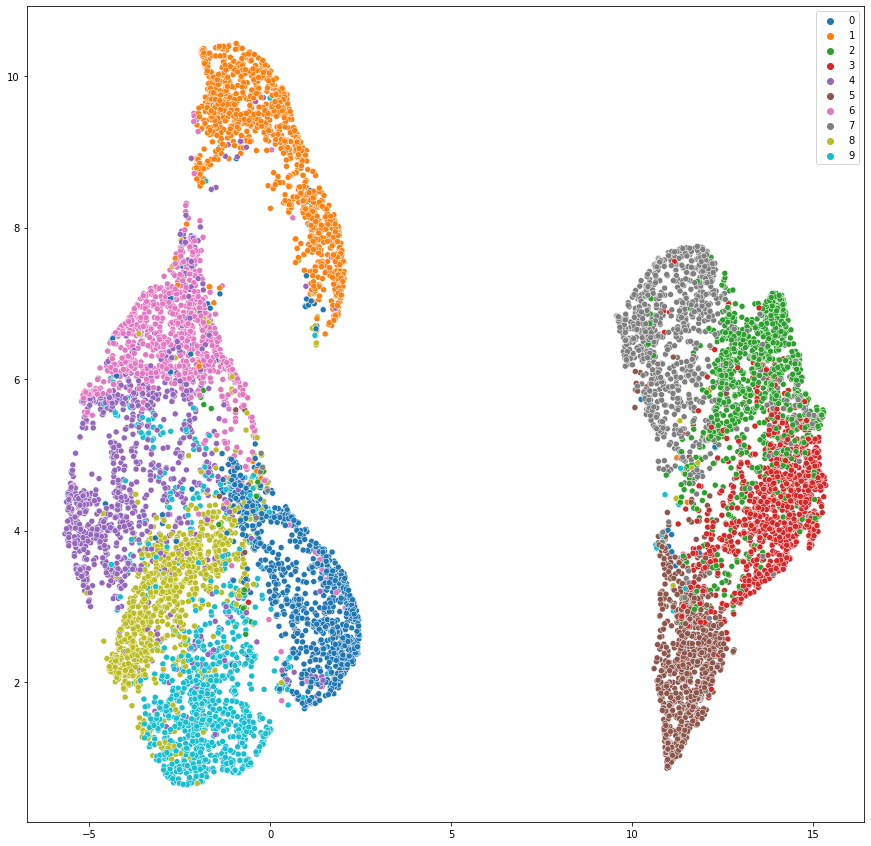

In [ ]:
plt.figure(figsize=(15,15))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=targets.astype(str), hue_order=[str(i) for i in range(10)])
plt.show()

In [ ]:
def experiment_criteria(metacriteria, epochs=3, dataset_train=False, dataset_test=False, n_train=50000, n_test=5000, batch_size=64,batch_size_test=1000, UMAP=True):
  #settings
  lr=1
  gamma=0.7
  seed=42
  no_cuda=False
  use_cuda = not no_cuda and torch.cuda.is_available()
  torch.manual_seed(seed)
  device = torch.device("cuda" if use_cuda else "cpu")
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

  if not dataset_train and dataset_test:
    #download training data if not included
    dataset_train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
    # download testing data if not included
    dataset_test = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
  #train data
  triplet_dataset_train = ImageTripletDataset(dataset_train, n_train, metacriteria)
  train_loader = torch.utils.data.DataLoader(
    triplet_dataset_train,
    batch_size=batch_size, shuffle=True, **kwargs)
  
  #test data
  triplet_dataset_test = ImageTripletDataset(dataset_test, n_test, metacriteria)
  test_loader = torch.utils.data.DataLoader(
    triplet_dataset_test,
    batch_size=batch_size_test, shuffle=True, **kwargs)
  
  model = TripletNet().to(device)

  optimizer = optim.Adadelta(model.parameters(), lr=lr)
  scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
  criteria = nn.BCELoss()

  for epoch in range(1, epochs + 1):
    train_loss = train(model, criteria, device, train_loader, optimizer)
    test_loss, outputs, targets = test(model, criteria, device, test_loader)
    scheduler.step()

    roc_auc = roc_auc_score(targets.cpu().numpy(), outputs.cpu().numpy())

    print("Train loss: %0.3f. Test loss: %0.3f. AUROC: %0.3f" % (train_loss, test_loss, roc_auc))

  if UMAP:
    encoder = model.encoder
    image_loader_test = torch.utils.data.DataLoader(
      dataset_test,
      batch_size=batch_size_test, shuffle=True, **kwargs)

    outputs, targets = get_encodings(encoder, device, image_loader_test)
    
    test_embeddings = outputs.cpu().numpy()
    targets = targets.cpu().numpy() 

    reducer = umap.UMAP()
    embedding = reducer.fit_transform(test_embeddings)
    embedding.shape

    plt.figure(figsize=(15,15))
    sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=targets.astype(str), hue_order=[str(i) for i in range(10)])
    plt.show()

Train loss: 0.693. Test loss: 0.693. AUROC: 0.500
Train loss: 0.693. Test loss: 0.692. AUROC: 0.610
Train loss: 0.681. Test loss: 0.677. AUROC: 0.791


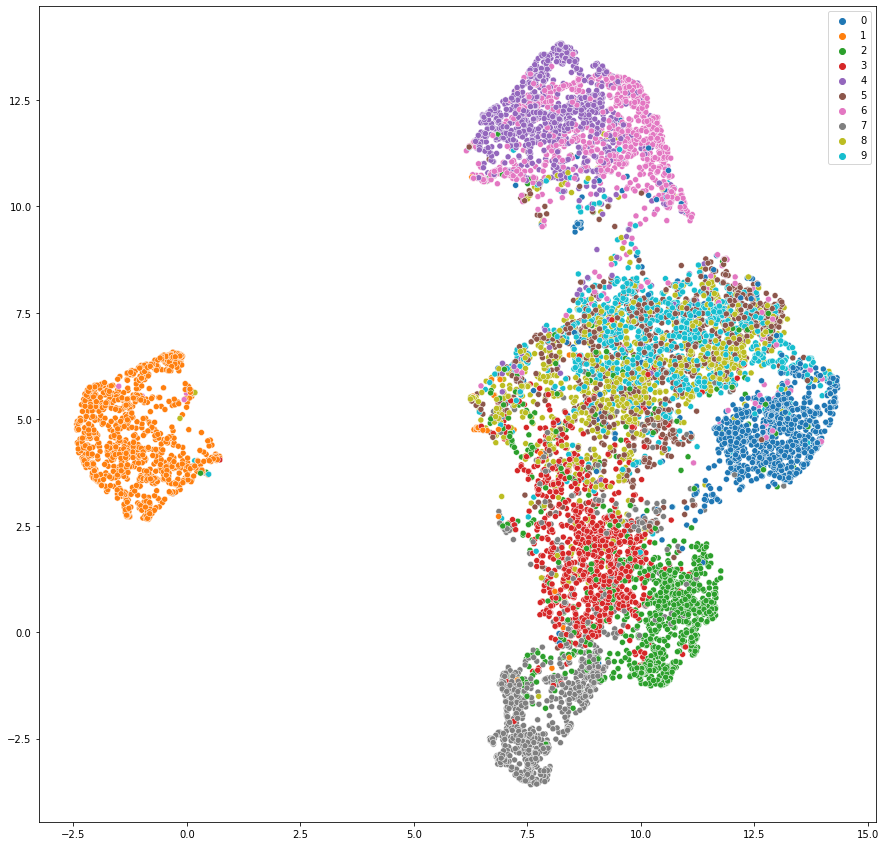

In [ ]:
experiment_criteria(metacriteria_sameNumber, dataset_train=image_dataset_train, dataset_test=image_dataset_test)